### Importing file


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


from collections import Counter
import numpy as np

class Node:
    """
    A node class for a decision tree.
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        """
        A node class for a decision tree.
        """
        return self.value is not None


class DecisionTree:
    """
    Decision Tree Classifier Class
    """
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
        


### Data Import


In [22]:
def importdata():
    balance_data = pd.read_csv(
        'https://archive.ics.uci.edu/ml/machine-learning-' +
        'databases/balance-scale/balance-scale.data',
        sep=',', header=None)
 
    # Displaying dataset information
    print("Dataset Length: ", len(balance_data))
    print("Dataset Shape: ", balance_data.shape)
    print("Dataset: ", balance_data.head())
     
    return balance_data

### Data Splitting


In [23]:
def splitdataset(balance_data):
 
    # Separating the target variable
    X = balance_data.values[:, 1:5]
    Y = balance_data.values[:, 0]
 
    # Splitting the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.3, random_state=100)
    
    
 
    return X, Y, X_train, X_test, y_train, y_test

### Prediction and Evaluation:


In [26]:
# Function to make predictions
def prediction(X_test, clf_object):
    y_pred = clf_object.predict(X_test)
    print("Predicted values:")
    print(y_pred)
    return y_pred
 
# Placeholder function for cal_accuracy
def cal_accuracy(y_test, y_pred):
    print("Confusion Matrix: ",
          confusion_matrix(y_test, y_pred))
    print("Accuracy : ",
          accuracy_score(y_test, y_pred)*100)
    print("Report : ",
          classification_report(y_test, y_pred))

### Plots the Decision Tree


In [27]:
# Function to plot the decision tree
def plot_decision_tree(clf_object, feature_names, class_names):
    plt.figure(figsize=(15, 10))
    plot_tree(clf_object, filled=True, feature_names=feature_names, class_names=class_names, rounded=True)
    plt.show()

Dataset Length:  625
Dataset Shape:  (625, 5)
Dataset:     0  1  2  3  4
0  B  1  1  1  1
1  R  1  1  1  2
2  R  1  1  1  3
3  R  1  1  1  4
4  R  1  1  1  5


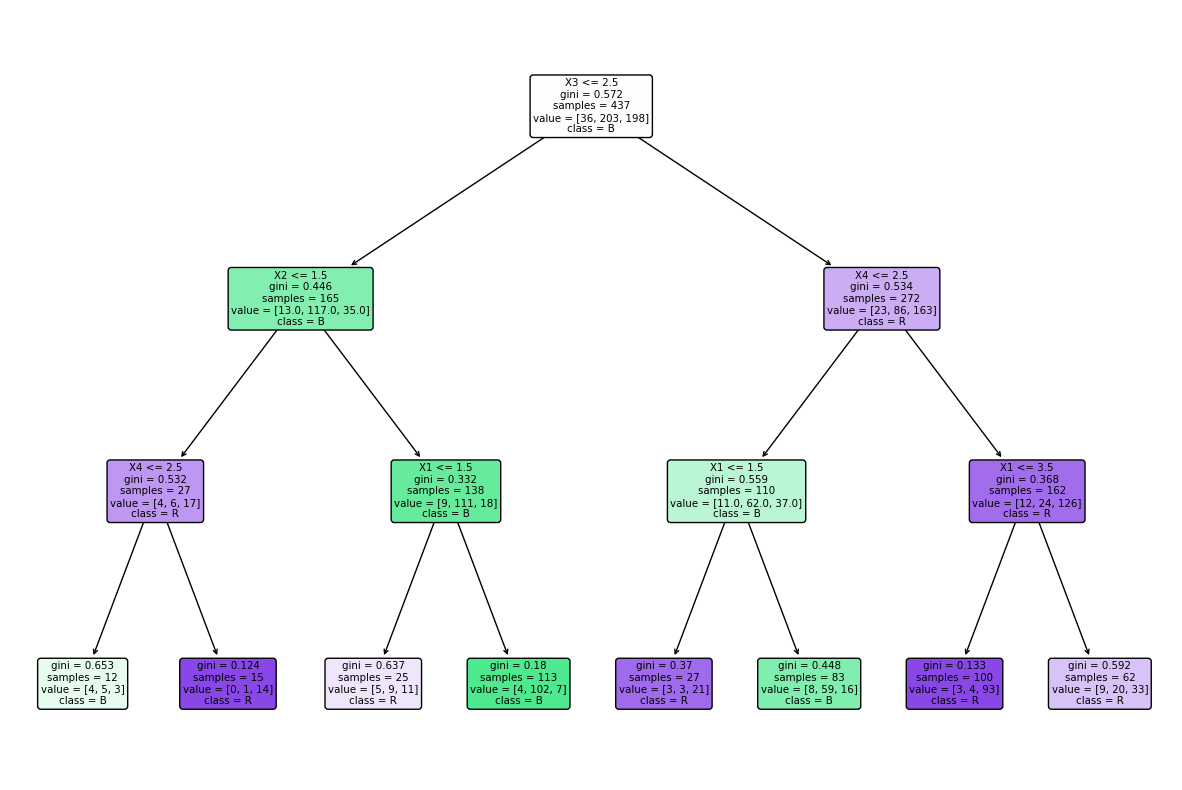

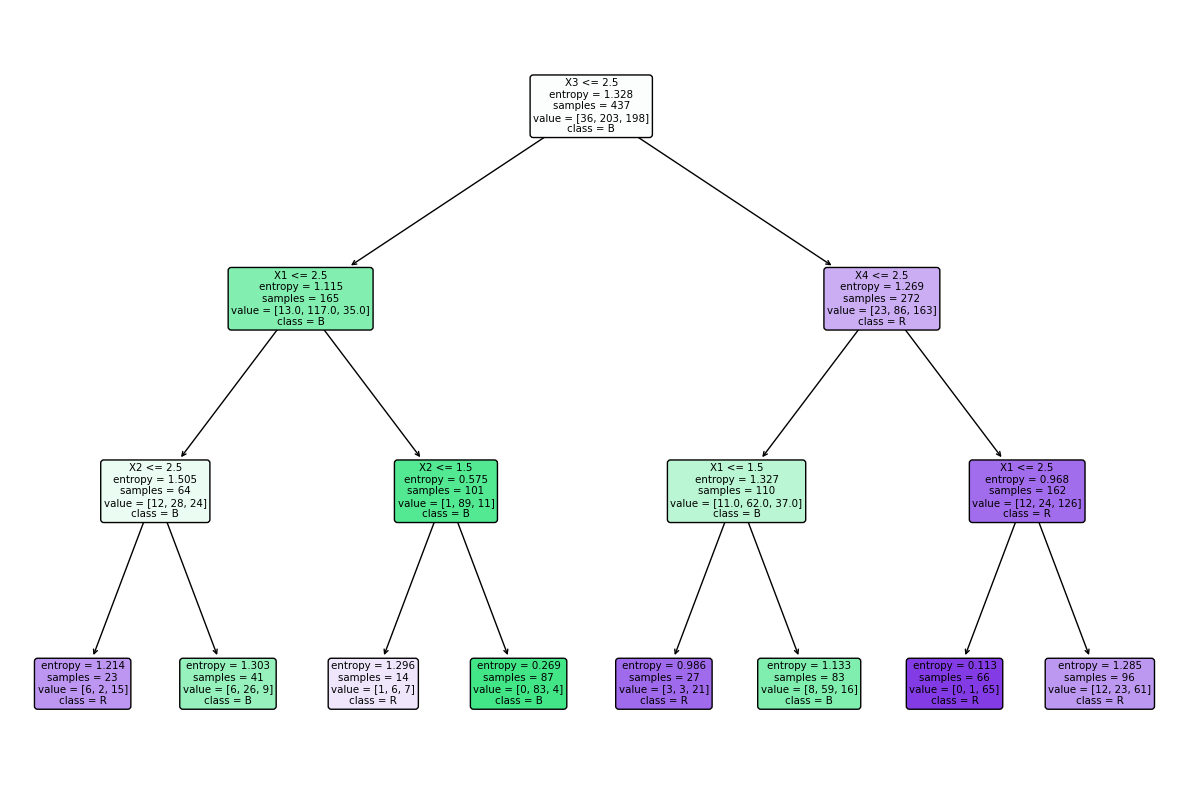

In [28]:
if __name__ == "__main__":
    data = importdata()
    X, Y, X_train, X_test, y_train, y_test = splitdataset(data)
 

    # Decision Tree use my custom class
    clf_gini = DecisionTree(max_depth=3)
    clf_gini.fit(X_train, y_train)
    y_pred_gini = clf_gini.predict(X_test)
    cal_accuracy(y_test, y_pred_gini)

    
 
    # Visualizing the Decision Trees
    plot_decision_tree(clf_gini, ['X1', 'X2', 'X3', 'X4'], ['L', 'B', 'R'])

### Results using Gini Index


In [29]:
# Operational Phase
print("Results Using Gini Index:")
y_pred_gini = prediction(X_test, clf_gini)
cal_accuracy(y_test, y_pred_gini)

Results Using Gini Index:
Predicted values:
['R' 'L' 'R' 'R' 'R' 'L' 'R' 'L' 'L' 'L' 'R' 'L' 'L' 'L' 'R' 'L' 'R' 'L'
 'L' 'R' 'L' 'R' 'L' 'L' 'R' 'L' 'L' 'L' 'R' 'L' 'L' 'L' 'R' 'L' 'L' 'L'
 'L' 'R' 'L' 'L' 'R' 'L' 'R' 'L' 'R' 'R' 'L' 'L' 'R' 'L' 'R' 'R' 'L' 'R'
 'R' 'L' 'R' 'R' 'L' 'L' 'R' 'R' 'L' 'L' 'L' 'L' 'L' 'R' 'R' 'L' 'L' 'R'
 'R' 'L' 'R' 'L' 'R' 'R' 'R' 'L' 'R' 'L' 'L' 'L' 'L' 'R' 'R' 'L' 'R' 'L'
 'R' 'R' 'L' 'L' 'L' 'R' 'R' 'L' 'L' 'L' 'R' 'L' 'R' 'R' 'R' 'R' 'R' 'R'
 'R' 'L' 'R' 'L' 'R' 'R' 'L' 'R' 'R' 'R' 'R' 'R' 'L' 'R' 'L' 'L' 'L' 'L'
 'L' 'L' 'L' 'R' 'R' 'R' 'R' 'L' 'R' 'R' 'R' 'L' 'L' 'R' 'L' 'R' 'L' 'R'
 'L' 'L' 'R' 'L' 'L' 'R' 'L' 'R' 'L' 'R' 'R' 'R' 'L' 'R' 'R' 'R' 'R' 'R'
 'L' 'L' 'R' 'R' 'R' 'R' 'L' 'R' 'R' 'R' 'L' 'R' 'L' 'L' 'L' 'L' 'R' 'R'
 'L' 'R' 'R' 'L' 'L' 'R' 'R' 'R']
Confusion Matrix:  [[ 0  6  7]
 [ 0 67 18]
 [ 0 19 71]]
Accuracy :  73.40425531914893
Report :                precision    recall  f1-score   support

           B       0.00      0.00      0.

/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

### Results using Entropy


In [30]:
print("Results Using Entropy:")
y_pred_entropy = prediction(X_test, clf_entropy)
cal_accuracy(y_test, y_pred_entropy)

Results Using Entropy:
Predicted values:
['R' 'L' 'R' 'L' 'R' 'L' 'R' 'L' 'R' 'R' 'R' 'R' 'L' 'L' 'R' 'L' 'R' 'L'
 'L' 'R' 'L' 'R' 'L' 'L' 'R' 'L' 'R' 'L' 'R' 'L' 'R' 'L' 'R' 'L' 'L' 'L'
 'L' 'L' 'R' 'L' 'R' 'L' 'R' 'L' 'R' 'R' 'L' 'L' 'R' 'L' 'L' 'R' 'L' 'L'
 'R' 'L' 'R' 'R' 'L' 'R' 'R' 'R' 'L' 'L' 'R' 'L' 'L' 'R' 'L' 'L' 'L' 'R'
 'R' 'L' 'R' 'L' 'R' 'R' 'R' 'L' 'R' 'L' 'L' 'L' 'L' 'R' 'R' 'L' 'R' 'L'
 'R' 'R' 'L' 'L' 'L' 'R' 'R' 'L' 'L' 'L' 'R' 'L' 'L' 'R' 'R' 'R' 'R' 'R'
 'R' 'L' 'R' 'L' 'R' 'R' 'L' 'R' 'R' 'L' 'R' 'R' 'L' 'R' 'R' 'R' 'L' 'L'
 'L' 'L' 'L' 'R' 'R' 'R' 'R' 'L' 'R' 'R' 'R' 'L' 'L' 'R' 'L' 'R' 'L' 'R'
 'L' 'R' 'R' 'L' 'L' 'R' 'L' 'R' 'R' 'R' 'R' 'R' 'L' 'R' 'R' 'R' 'R' 'R'
 'R' 'L' 'R' 'L' 'R' 'R' 'L' 'R' 'L' 'R' 'L' 'R' 'L' 'L' 'L' 'L' 'L' 'R'
 'R' 'R' 'L' 'L' 'L' 'R' 'R' 'R']
Confusion Matrix:  [[ 0  6  7]
 [ 0 63 22]
 [ 0 20 70]]
Accuracy :  70.74468085106383
Report :                precision    recall  f1-score   support

           B       0.00      0.00      0.00 

/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",